In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import h5py
sys.path.append('/global/u2/t/tvnguyen/sbi_stream')
sys.path.append('/global/homes/r/rutong/sbi_stream')  # add sbi_stream parent directory to path
import pickle

import corner
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import astropy.constants as const
import astropy.units as u
from torch.utils.data import TensorDataset, DataLoader
import yaml
from ml_collections import ConfigDict

from tqdm import tqdm

import datasets
from models.zuko import regressor as zuko_regressor
from models.zuko import infer_utils
from datasets import io_utils, preprocess_utils

%matplotlib inline

In [64]:
run_dir = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/trained-models/'
# run_name ='6params-aau-ta25-corr/hilmi24-nw-sf1'
# run_name ='6params-aau-ta25-corr/spline-sf1'
run_name ='6params-aau-ta25-corr/spline-nw-sf1'

# run_name ='6params-aau-ta25-vtotal/hilmi24-nw-sf1'
# run_name ='6params-aau-ta25-vtotal/spline-sf1'
# run_name ='6params-aau-ta25-vtotal/spline-nw-sf1'
use_vtotal = False

with open(os.path.join(run_dir, run_name, 'config.yaml'), 'r') as f:
    config = ConfigDict(yaml.unsafe_load(f))

sorted(glob.glob(os.path.join(run_dir, run_name, 'lightning_logs/checkpoints/*')))

['/pscratch/sd/t/tvnguyen/stream_sbi_shared/trained-models/6params-aau-ta25-corr/spline-nw-sf1/lightning_logs/checkpoints/epoch=1028-step=193452-train_loss=-0.5672-val_loss=-1.3404.ckpt',
 '/pscratch/sd/t/tvnguyen/stream_sbi_shared/trained-models/6params-aau-ta25-corr/spline-nw-sf1/lightning_logs/checkpoints/epoch=1054-step=198340-train_loss=-0.5859-val_loss=-1.3176.ckpt',
 '/pscratch/sd/t/tvnguyen/stream_sbi_shared/trained-models/6params-aau-ta25-corr/spline-nw-sf1/lightning_logs/checkpoints/epoch=1104-step=207740-train_loss=-0.6478-val_loss=-1.3028.ckpt',
 '/pscratch/sd/t/tvnguyen/stream_sbi_shared/trained-models/6params-aau-ta25-corr/spline-nw-sf1/lightning_logs/checkpoints/epoch=920-step=173148-train_loss=-0.4337-val_loss=-1.3023.ckpt',
 '/pscratch/sd/t/tvnguyen/stream_sbi_shared/trained-models/6params-aau-ta25-corr/spline-nw-sf1/lightning_logs/checkpoints/epoch=968-step=182172-train_loss=-0.4837-val_loss=-1.3073.ckpt']

In [65]:
# checkpoint = 'epoch=996-step=187436-train_loss=-0.0711-val_loss=-1.1274.ckpt'
# checkpoint = 'epoch=711-step=133856-train_loss=-0.0487-val_loss=-0.6246.ckpt'
checkpoint = 'epoch=1028-step=193452-train_loss=-0.5672-val_loss=-1.3404.ckpt'

# checkpoint = 'epoch=1133-step=213192-train_loss=-0.2710-val_loss=-1.0722.ckpt'
# checkpoint = 'epoch=678-step=127652-train_loss=-0.1137-val_loss=-0.8881.ckpt'
# checkpoint = 'epoch=1000-step=188188-train_loss=-0.1516-val_loss=-1.0191.ckpt'

checkpoint_path = os.path.join(
    run_dir, run_name, 'lightning_logs/checkpoints/', checkpoint)
features = ['phi1', 'phi2', 'pm1', 'pm2', 'vr', 'dist']
labels = ['log_M_sat', 'log_rs_sat', 'vz', 'vphi', 'r', 'phi']

# read in the dataset and run on the validation dataset
device = torch.device('cpu')
model = zuko_regressor.Regressor.load_from_checkpoint(checkpoint_path, map_location=device).eval()

In [66]:
datadir = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/datasets/aau-ta25-corr/'
# print(config.data)

# data_raw, _ = datasets.io_utils.read_dataset(os.path.join(datadir, 'data.0.hdf5'))
# phi1_raw = data_raw['phi1'][0]
# phi2_raw = data_raw['phi2'][0]

x, y, t, padding_mask = datasets.read_process_dataset(
    datadir,
    features=config.data.features,
    labels=config.data.labels,
    binning_fn=config.data.binning_fn,
    binning_args=config.data.binning_args,
    frac=config.data.frac,
    use_width=config.data.use_width,
    num_datasets=1,
    num_subsamples=1,
    subsample_factor=config.data.subsample_factor
)

x_norm = (x - model.norm_dict['x_loc']) / model.norm_dict['x_scale']
y_norm = (y - model.norm_dict['y_loc']) / model.norm_dict['y_scale']
t_norm = (t - model.norm_dict['t_loc']) / model.norm_dict['t_scale']
x_norm = torch.tensor(x_norm, dtype=torch.float32)
y_norm = torch.tensor(y_norm, dtype=torch.float32)
t_norm = torch.tensor(t_norm, dtype=torch.float32)
padding_mask = torch.tensor(padding_mask, dtype=torch.bool)

Reading in data from /pscratch/sd/t/tvnguyen/stream_sbi_shared/datasets/aau-ta25-corr/data.0.hdf5


Processing pid 0: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


In [67]:
loader = DataLoader(
    TensorDataset(x_norm, y_norm, t_norm, padding_mask),
    batch_size=512
)
# validation
pl.seed_everything(40)
samples, truths = infer_utils.sample(
    model, loader,50_000, norm_dict=model.norm_dict)
samples = samples[0]
truths = truths[0]

[rank: 0] Seed set to 40
Sampling:   0%|                                                                  | 0/1 [00:00<?, ?it/s]

Sampling: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


In [68]:
samples[:, 5][samples[:, 5] > 360] -= 360
samples[:, 5][samples[:, 5] < 0] += 360
if use_vtotal:
    priors_range = (
        [-4, -2],
        [np.log10(0.1), np.log10(0.5)],
        [-60, 40],
        [0, 100],
        [0, 1],
        [0, 360],
    )
    samples[:, 3] = np.sqrt(samples[:, 2]**2 + samples[:, 3]**2)
else:
    priors_range = (
        [-4, -2],
        [np.log10(0.1), np.log10(0.5)],
        [-60, 40],
        [-15, 85],
        [0, 1],
        [0, 360],
    )

mask = np.zeros(len(samples), dtype=bool)
for i in range(len(priors_range)):
    s = samples[:, i]
    pmin, pmax = priors_range[i]
    mask = mask | ((s < pmin) | (s > pmax))
samples = samples[~mask]

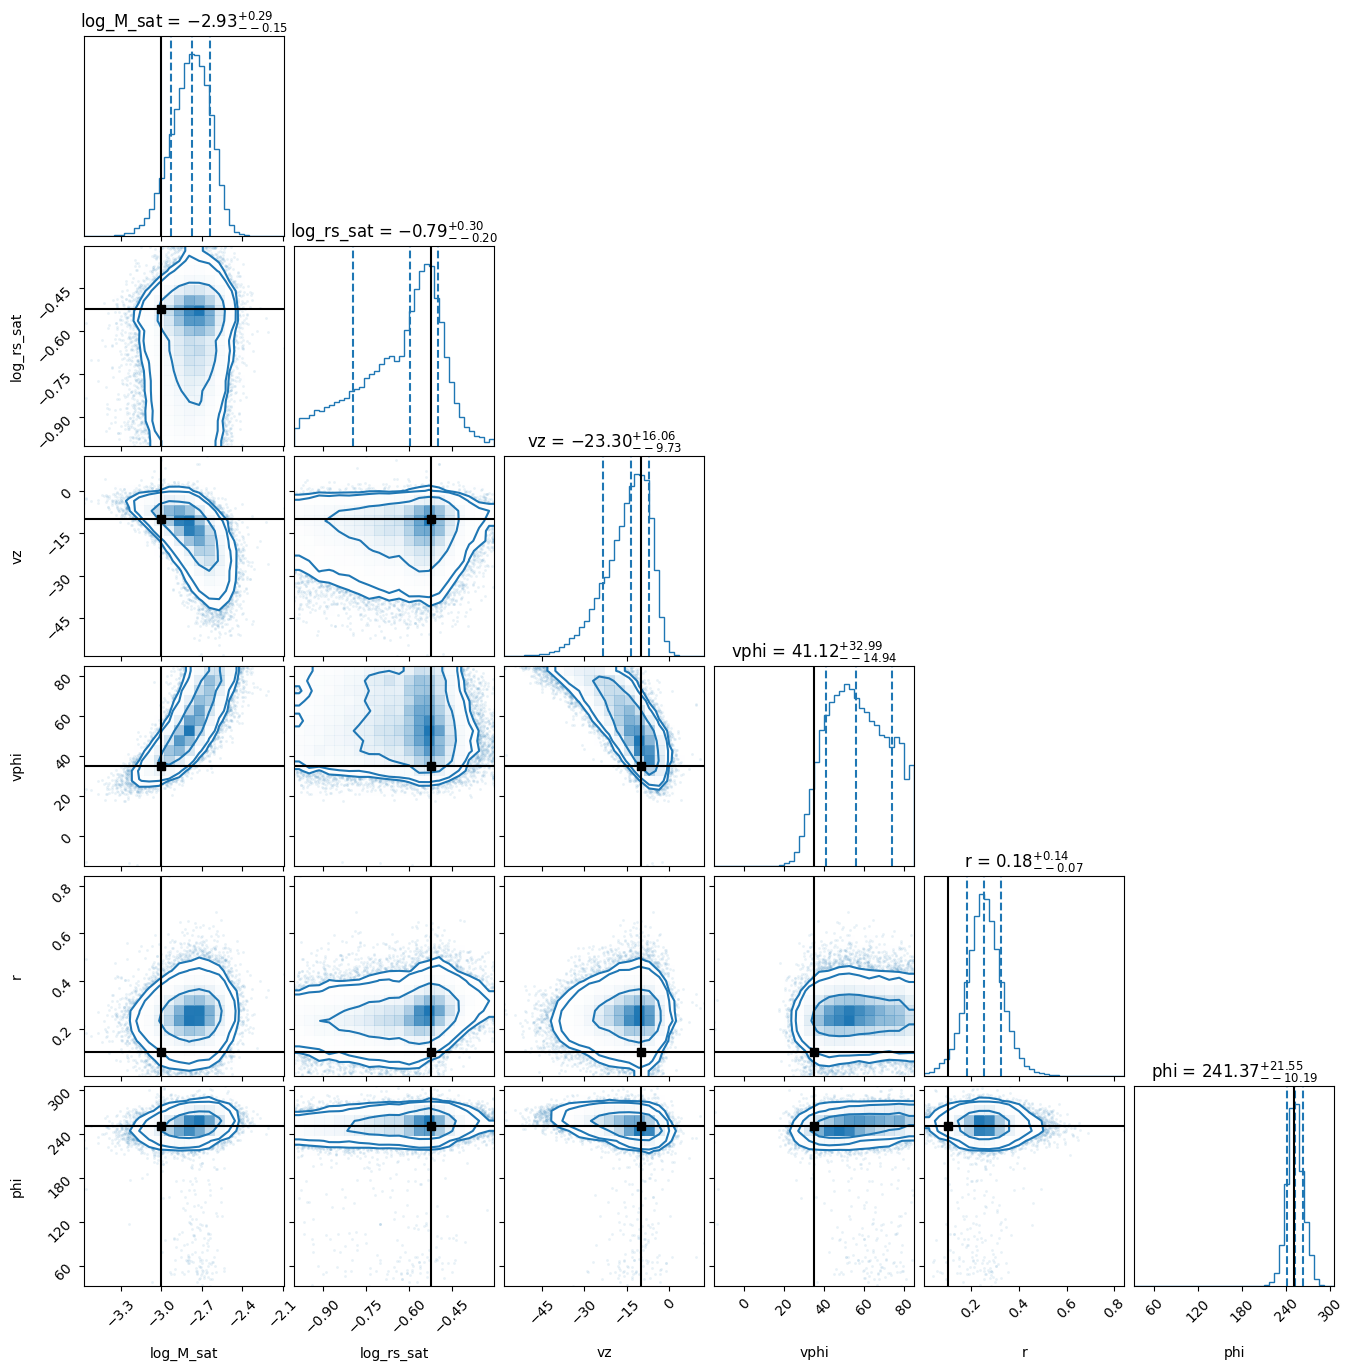

In [69]:
# corner plot
fig = corner.corner(
    samples,
    truths=truths,
    truth_color='black',
    levels=(0.68, 0.95, 0.975),
    quantiles=(0.5, 0.16, 0.84),
    show_titles=True,
    labels=labels,
    title_kwargs={"fontsize": 12},
    plot_contours=True,
    color='C0',
    hist_bin_factor=2,
    smooth=0,
    fill_contours=False,
    plot_density=True,
)

In [47]:
# with h5py.File('/global/homes/r/rutong/sbi_stream/posteriors/spline-nw-sf1.hdf5', 'w') as f:
#     f.create_dataset('M_sat', data=10**samples[:, 0])
#     f.create_dataset('rs_sat', data=10**samples[:, 1])
#     f.create_dataset('vz', data=samples[:, 2])
#     f.create_dataset('vphi', data=samples[:, 3])
#     f.create_dataset('r', data=samples[:, 4])
#     f.create_dataset('phi', data=samples[:, 5])
#     f.create_dataset('phi_a', data=np.full_like(samples[:, 0], -4))
#     f.create_dataset('t_a', data=np.full_like(samples[:, 0], 0.2))
#     f.create_dataset('tmax', data=np.full_like(samples[:, 0], 4))

In [4]:
%cd /global/homes/r/rutong/sbi_stream

/global/u2/r/rutong/sbi_stream


In [6]:
data_raw_dir = '/pscratch/sd/t/tvnguyen/stream_sbi/datasets/aau'
binning_args = {}
binning_args['num_bins'] = 50
binning_args['phi1_min'] = -20
binning_args['phi1_max'] = 12

data = datasets.read_process_dataset(
    data_raw_dir,
    features=['phi2', 'pm1', 'pm2', 'vr', 'dist'],
    labels=['log_M_sat', 'log_rs_sat', 'vz', 'vphi', 'r_sin_phi', 'r_cos_phi'],
    binning_fn='bin_stream_spline',
    binning_args = binning_args,
    frac=True
)

Reading in data from /pscratch/sd/t/tvnguyen/stream_sbi/datasets/aau/data.0.hdf5


Processing pid 1: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.65it/s]


In [7]:
checkpoint_path = '/pscratch/sd/t/tvnguyen/stream_sbi/logging/silly-tract-83/lightning_logs/checkpoints/epoch=601-step=1798174-train_loss=-3.5185-val_loss=-3.3489.ckpt'
model = regressor.Regressor.load_from_checkpoint(
    checkpoint_path)

/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.3


In [8]:
num_posteriors = 10

posteriors = []
truths = []

for i in range(num_posteriors):
    train_loader, val_loader, norm_dict = datasets.prepare_dataloader(
        data, train_frac=0.8, train_batch_size=1024, eval_batch_size=128, num_workers=4,
        norm_dict=model.norm_dict, seed=i,  # reset seed for splitting train/val
    )
    posterior, truths = infer_utils.sample(model, val_loader, num_samples=1, 
        return_labels=True, norm_dict=norm_dict)
    posteriors.append(posterior)

posteriors = np.concatenate(posteriors, axis=1)

[rank: 0] Seed set to 0
Sampling:   0%|                                                                              | 0/1 [00:00<?, ?it/s]/global/homes/r/rutong/.conda/envs/sbi/lib/python3.11/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
Sampling: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]
[rank: 0] Seed set to 1
Sampling: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.54it/s]
[rank: 0] Seed set to 2
Sampling: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.53it/s]
[rank: 0] Seed set to 3
Sampling: 100%|███████████████████████████████████████████

In [9]:
posteriors

array([[[-1.48156285e+00, -1.67168270e+00,  2.91501396e+01,
         -5.38805529e+00, -2.37761399e+00, -1.66117822e+00],
        [-1.59779047e+00, -1.06298154e+00,  4.19254145e+01,
          9.76093285e+00, -1.29001629e-01, -1.01498743e+00],
        [-1.01263973e+00, -5.09333571e-01,  1.75187431e+01,
         -7.87876011e+01, -2.29190549e+00, -8.92268933e-01],
        [-1.56418507e+00, -4.40460996e-01,  2.04023029e+01,
          4.59102287e+01,  2.79174185e-01, -8.59645030e-01],
        [-1.33220885e+00, -1.36382217e+00,  1.56150275e+01,
          2.19050812e+01, -2.48291350e+00, -9.03596200e-01],
        [-1.39274072e+00, -8.96184473e-01,  3.66160346e+01,
         -3.18826072e+01, -7.39714021e-01, -2.15188722e+00],
        [-1.01402855e+00, -9.06286600e-01,  3.00776031e+01,
         -4.36651349e+01, -7.08165708e-01, -1.42411745e+00],
        [-1.09526827e+00, -8.84462227e-01,  3.73266183e+01,
         -5.95800816e+01, -4.25213067e+00, -6.24052189e-01],
        [-1.80194939e+00, -1.450

In [9]:
truths

array([[-3.00000000e+00, -5.22878745e-01,  3.50000011e+01,
        -9.99999977e+00, -9.39692605e-02, -3.42020135e-02]])

In [7]:
import corner

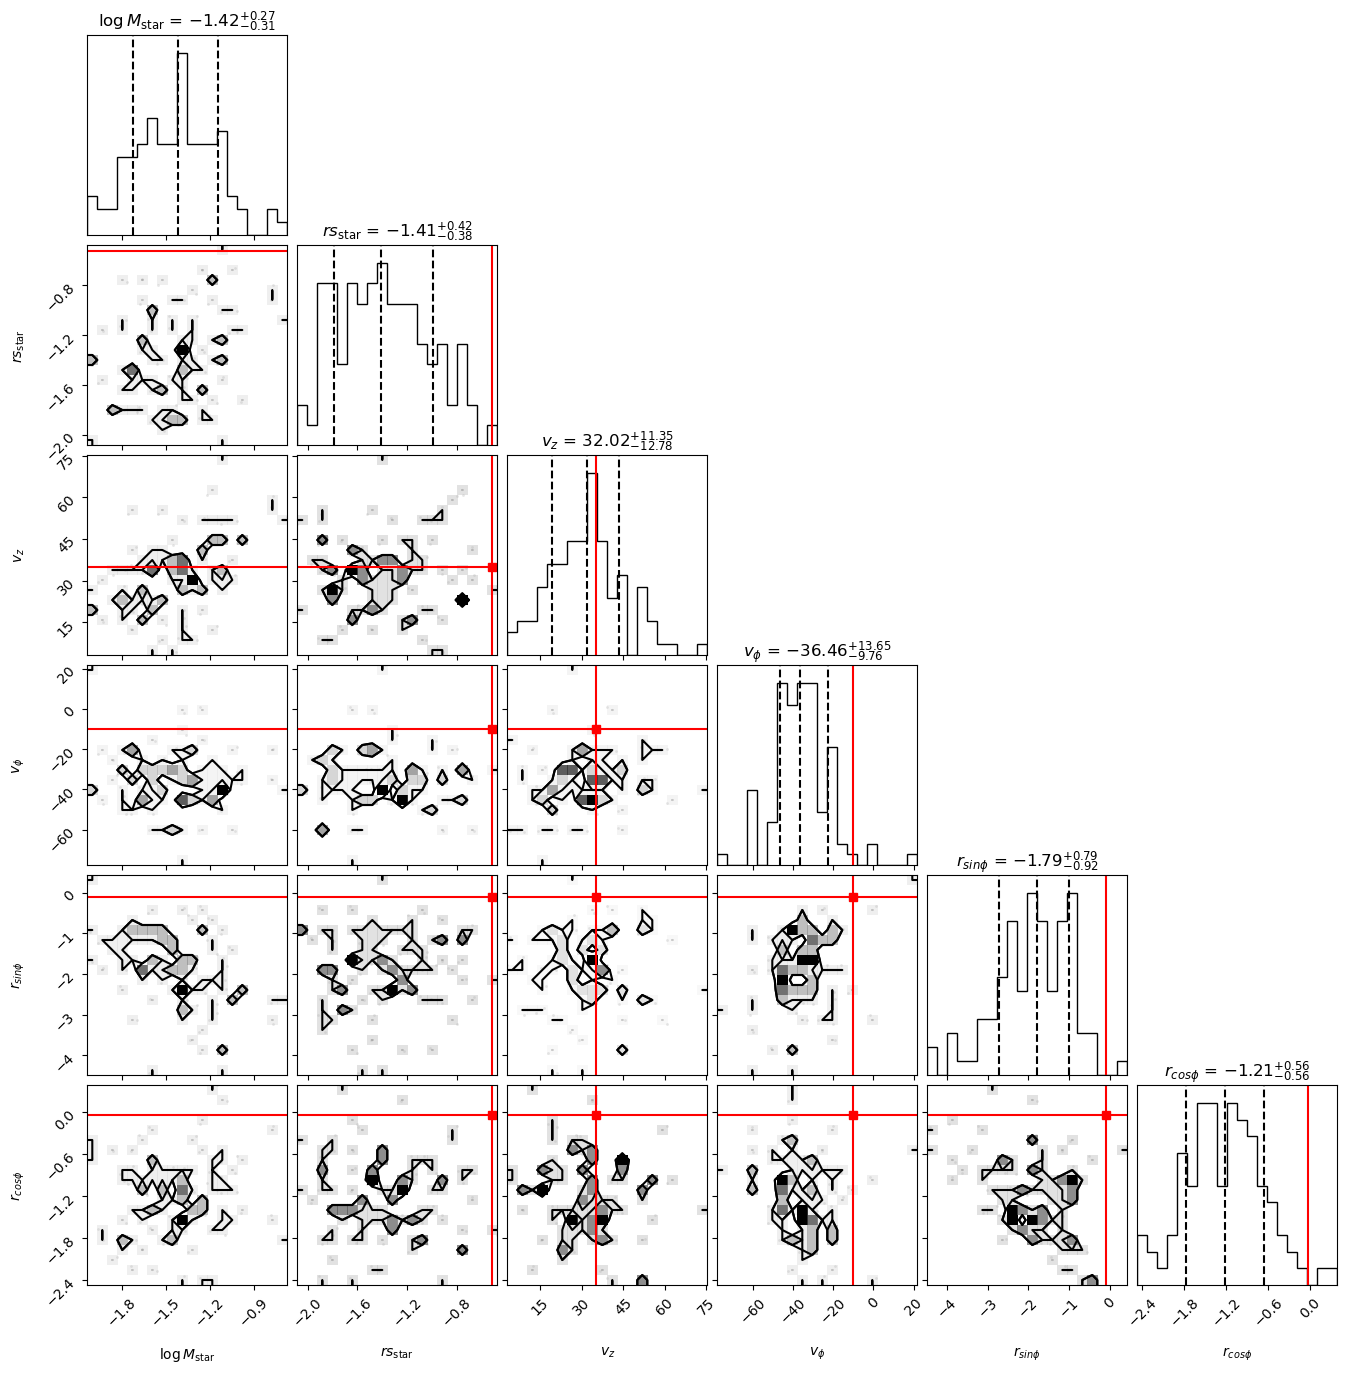

In [12]:
index = 0
fig = corner.corner(
    posteriors[index], 
    truths=truths[index],
    truth_color='r', 
    levels=[0.68, 0.95],
    quantiles=[0.16, 0.5, 0.84],
    labels=[r'$\log M_{\rm star}$', r'$rs_{\rm star}$', r'$v_z$', r'$v_{\phi}$', r'$r_{sin \phi}$', r'$r_{cos \phi}$'],
    show_titles=True,
)

In [12]:
# save params to hdf5
aau_posteriors = posteriors[0]
logM = posteriors[:, 0]
rs = posteriors[:, 1]
vz = posteriors[:, 2]
vphi = posteriors[:, 3]
rsin = posteriors[:, 4]
rcos = posteriors[:, 5] 
with h5py.File('aau_posteriors.hdf5', 'w') as f:
    f.create_dataset('logM', data=logM)
    f.create_dataset('rs', data=rs)
    f.create_dataset('vz', data=vz)
    f.create_dataset('vphi', data=vphi)
    f.create_dataset('rcos', data=rcos)
    f.create_dataset('rsin', data=rsin)

In [15]:
params_list = np.array([logM, rs, vz])
params_list.T

array([[-1.48156285, -1.6716827 , 29.15013964],
       [-1.59779047, -1.06298154, 41.92541448],
       [-1.01263973, -0.50933357, 17.51874312],
       [-1.56418507, -0.440461  , 20.40230289],
       [-1.33220885, -1.36382217, 15.6150275 ],
       [-1.39274072, -0.89618447, 36.61603456],
       [-1.01402855, -0.9062866 , 30.07760307],
       [-1.09526827, -0.88446223, 37.32661827],
       [-1.80194939, -1.4509421 , 18.22490354],
       [-1.43610811, -1.36147944, 22.15653697]])

In [1]:
import sys
import h5py

sys.path.append('..')  # add sbi_stream parent directory to path

import numpy as np

In [3]:
with h5py.File('/global/homes/r/rutong/sbi_stream/aau_posteriors.hdf5', 'r') as f:
        logM = f['logM'][:]
        rs = f['rs'][:]
        vz = f['vz'][:]
        vphi = f['vphi'][:]
        rcos = f['rcos'][:]
        rsin = f['rsin'][:]

# convert to run_sim params
r = np.sqrt(rcos**2 + rsin**2)
m = np.power(10, logM)
phi = np.degrees(np.arctan2(rsin, rcos))
sample_len = len(m)
tmax = np.full(sample_len, 4)
t_a = np.full(sample_len, 0.25)
phi_a = np.full(sample_len, -6)
params_list = np.array([r, phi, vphi, vz, m, tmax, t_a, phi_a, rs])
params_list.T  # each row a set of params for 1 stream

array([[ 2.90044158e+00, -1.24941018e+02, -5.38805529e+00,
         2.91501396e+01,  3.29941655e-02,  4.00000000e+00,
         2.50000000e-01, -6.00000000e+00, -1.67168270e+00],
       [ 1.02315243e+00, -1.72756726e+02,  9.76093285e+00,
         4.19254145e+01,  2.52469855e-02,  4.00000000e+00,
         2.50000000e-01, -6.00000000e+00, -1.06298154e+00],
       [ 2.45946633e+00, -1.11271617e+02, -7.87876011e+01,
         1.75187431e+01,  9.71315381e-02,  4.00000000e+00,
         2.50000000e-01, -6.00000000e+00, -5.09333571e-01],
       [ 9.03840585e-01,  1.62008526e+02,  4.59102287e+01,
         2.04023029e+01,  2.72781512e-02,  4.00000000e+00,
         2.50000000e-01, -6.00000000e+00, -4.40460996e-01],
       [ 2.64222360e+00, -1.09997750e+02,  2.19050812e+01,
         1.56150275e+01,  4.65362250e-02,  4.00000000e+00,
         2.50000000e-01, -6.00000000e+00, -1.36382217e+00],
       [ 2.27547697e+00, -1.61029526e+02, -3.18826072e+01,
         3.66160346e+01,  4.04817504e-02,  4.000000